In [ ]:
# !pip show tensorflow

Name: tensorflow
Version: 2.0.4
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /home/aleef/anaconda3/envs/abdul/lib/python3.6/site-packages
Requires: grpcio, gast, termcolor, numpy, keras-applications, protobuf, h5py, absl-py, wrapt, wheel, six, tensorflow-estimator, tensorboard, opt-einsum, google-pasta, astor, keras-preprocessing
Required-by: 


In [ ]:
# !pip install google-cloud-translate

In [ ]:
!pip install pyngrok
!pip install flask_ngrok

In [ ]:
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="./radiant-gateway-423216-t1-6a61a5b841e0.json"
# os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/home/aleef/Downloads/radiant-gateway-423216-t1-6a61a5b841e0.json"

In [ ]:
from google.cloud import translate_v2
translate_client = translate_v2.Client()

text = "Hello, world!"
target = 'fr'  # French
output = translate_client.translate(text, target_language=target)
print(output)


{'translatedText': 'Bonjour le monde!', 'detectedSourceLanguage': 'en', 'input': 'Hello, world!'}


In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow.keras.utils as ku
from wordcloud import WordCloud
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow import keras
from google.cloud import translate

In [ ]:
def detect_language(text: str):
    """Detect the text"""
    translate_client = translate.Client()
    response = translate_client.detect_language(text)
    return response['language']

def translate_text(text, target_language):

    translate_client = translate_v2.Client()

    output = translate_client.translate(text, target_language=target_language)

    return output['translatedText']

In [ ]:
ENG = pd.read_csv("English (Dataset).csv", encoding='utf-8', header=None, sep=',', names=['mistra1'])
Urdu = pd.read_csv("Poetry_Dataset_New.csv", encoding='utf-8', header=None, sep=',', names=['mistra1'])
Spanish = pd.read_csv("Spanish.csv", encoding='utf-8', header=None, sep=',', names=['mistra1'])
shayari= ENG[:2000]
print(shayari['mistra1'].unique())

['mistra1' 'I have wished a bird would fly away,'
 'And not sing by my house all day;' ...
 "'Twas throwing words away; for still"
 'The little Maid would have her will,' 'And said, "Nay, we are seven!"']


In [ ]:
len(shayari[:2000])

1843

In [ ]:
from tensorflow.keras.utils import to_categorical

# Fitting the Tokenizer on the Corpus
tokenizer = Tokenizer()
tokenizer.fit_on_texts(shayari['mistra1'])

# Vocabulary count of the corpus
total_words = len(tokenizer.word_index)
print("Total Words:", total_words)

# Converting the text into embeddings
input_sequences = []
for line in shayari['mistra1']:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

# Check if input_sequences is empty
if input_sequences:
    max_sequence_len = max([len(x) for x in input_sequences])
    input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
    predictors, label = input_sequences[:, :-1], input_sequences[:, -1]
    label = to_categorical(label, num_classes=total_words+1)
else:
    print("Error: No input sequences generated. Please check your corpus data.")


Total Words: 3065


# **Bi-Directional LSTM Model**

In [ ]:
    # Building a Bi-Directional LSTM Model
model_BiLSTM = Sequential()
model_BiLSTM.add(Embedding(total_words+1, 100, input_length=max_sequence_len-1))
model_BiLSTM.add(Bidirectional(LSTM(150, return_sequences=True)))
model_BiLSTM.add(Dropout(0.2))
model_BiLSTM.add(LSTM(100))
model_BiLSTM.add(Dense(total_words+1/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_BiLSTM.add(Dense(total_words+1, activation='softmax'))
model_BiLSTM.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])
print(model_BiLSTM.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 61, 100)           306600    
                                                                 
 bidirectional (Bidirection  (None, 61, 300)           301200    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 61, 300)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               160400    
                                                                 
 dense (Dense)               (None, 3065)              309565    
                                                                 
 dense_1 (Dense)             (None, 3066)              9400356   
                                                        

# **LSTM Model**

In [ ]:

# define the LSTM model
model_lstm = Sequential()
model_lstm.add(Embedding(total_words+1, 100, input_length=max_sequence_len-1))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(total_words+1, activation='softmax'))
model_lstm.compile(loss='categorical_crossentropy', optimizer='adam')
print(model_lstm.summary())


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 61, 100)           306600    
                                                                 
 dropout_1 (Dropout)         (None, 61, 100)           0         
                                                                 
 dense_2 (Dense)             (None, 61, 3066)          309666    
                                                                 
Total params: 616266 (2.35 MB)
Trainable params: 616266 (2.35 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


# **3. Gated Recurrent Unit (GRU)**

In [ ]:

# Parameters
embedding_dim = 300
gru_dim = 128
dense_dim = total_words+1

#define a model which used bidirection GRU, other details will be same as model_lstm

# Model Definition with GRU
model_gru = tf.keras.Sequential([
    tf.keras.layers.Embedding(total_words+1, 100, input_length=max_sequence_len-1),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(units=gru_dim)),#add an LSTM layer where the no of units is equal to lstm_dim),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(total_words+1, activation='sigmoid')
])

# Set the training parameters
# compile the above model for loss='binary_crossentropy',optimizer='adam',metrics=['accuracy']
model_gru.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_gru.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 61, 100)           306600    
                                                                 
 bidirectional_1 (Bidirecti  (None, 256)               176640    
 onal)                                                           
                                                                 
 dense_3 (Dense)             (None, 3066)              787962    
                                                                 
 dense_4 (Dense)             (None, 3066)              9403422   
                                                                 
Total params: 10674624 (40.72 MB)
Trainable params: 10674624 (40.72 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# **4. Convolutional Neural Networks (CNNs)**

In [ ]:
filters = 128
kernel_size = 5
dense_dim = total_words+1
# Model Definition with Conv1D
model_conv = tf.keras.Sequential([
    # add embedding layer with vocab_size, embedding_dim, input_length=max_length,
    #add Conv1D with filters, kernel_size, activation='relu' mentioned above,
    tf.keras.layers.Embedding(total_words+1, 100, input_length=max_sequence_len-1),
    tf.keras.layers.Conv1D(filters=filters, kernel_size=kernel_size),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(total_words+1, activation='sigmoid')
])

# Set the training parameters
# compile the above model for loss='binary_crossentropy',optimizer='adam',metrics=['accuracy']
model_conv.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_conv.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 61, 100)           306600    
                                                                 
 conv1d (Conv1D)             (None, 57, 128)           64128     
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense_5 (Dense)             (None, 3066)              395514    
                                                                 
 dense_6 (Dense)             (None, 3066)              9403422   
                                                                 
Total params: 10169664 (38.79 MB)
Trainable params: 10169664 (38.79 MB)
Non-trainable params: 0 (0.00 Byte)
____________

# **5.Flatten**

In [ ]:
# Model Definition with a Flatten layer
model_flatten = tf.keras.Sequential([
    # Add embedding layer with vocab_size, embedding_dim, input_length=max_length,
    tf.keras.layers.Embedding(total_words+1, 100, input_length=max_sequence_len-1),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(total_words+1, activation='relu'),
    tf.keras.layers.Dense(total_words+1, activation='sigmoid')
])

model_flatten.summary()
# Set the training parameters

# Add code below
optimizer = keras.optimizers.Adam(lr=0.001)
model_flatten.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['categorical_accuracy'])

# Print the model summary
model_flatten.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 61, 100)           306600    
                                                                 
 flatten (Flatten)           (None, 6100)              0         
                                                                 
 dense_7 (Dense)             (None, 3066)              18705666  
                                                                 
 dropout_2 (Dropout)         (None, 3066)              0         
                                                                 
 dense_8 (Dense)             (None, 3066)              9403422   
                                                                 
 dense_9 (Dense)             (None, 3066)              9403422   
                                                                 
Total params: 37819110 (144.27 MB)
Trainable params: 3

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 61, 100)           306600    
                                                                 
 flatten (Flatten)           (None, 6100)              0         
                                                                 
 dense_7 (Dense)             (None, 3066)              18705666  
                                                                 
 dropout_2 (Dropout)         (None, 3066)              0         
                                                                 
 dense_8 (Dense)             (None, 3066)              9403422   
                                                                 
 dense_9 (Dense)             (None, 3066)              9403422   
                                                                 
Total params: 37819110 (144.27 MB)
Trainable params: 3

In [ ]:
def preprocess_data(corpus):
    global predictors, label, max_sequence_len, total_words, tokenizer  # Declare globals

    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(corpus)

    total_words = len(tokenizer.word_index)
    print("Total Words:", total_words)

    input_sequences = []
    for line in corpus:
        token_list = tokenizer.texts_to_sequences([line])[0]
        for i in range(1, len(token_list)):
            n_gram_sequence = token_list[:i+1]
            input_sequences.append(n_gram_sequence)

    if input_sequences:
        max_sequence_len = max([len(x) for x in input_sequences])
        input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
        predictors, label = input_sequences[:, :-1], input_sequences[:, -1]
        label = to_categorical(label, num_classes=total_words+1)
    else:
        raise ValueError("No input sequences generated. Please check your corpus data.")

In [ ]:
def create_model_bilstm():
    model = Sequential()
    model.add(Embedding(total_words+1, 100, input_length=max_sequence_len-1))
    model.add(Bidirectional(LSTM(150, return_sequences=True)))
    model.add(Dropout(0.2))
    model.add(LSTM(100))
    model.add(Dense(total_words+1//2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dense(total_words+1, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    return model

In [ ]:
def create_model_lstm():
    model = Sequential()
    model.add(Embedding(total_words+1, 100, input_length=max_sequence_len-1))
    model.add(Dropout(0.2))
    model.add(Dense(total_words+1, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    print(model.summary())
    return model

In [ ]:
def create_model_gru():
    embedding_dim = 300
    gru_dim = 128
    dense_dim = total_words + 1
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(total_words+1, 100, input_length=max_sequence_len-1),
        tf.keras.layers.Bidirectional(tf.keras.layers.GRU(units=gru_dim)),
        tf.keras.layers.Dense(dense_dim, activation='relu'),
        tf.keras.layers.Dense(total_words+1, activation='sigmoid')
    ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    return model

In [ ]:
def create_model_conv():
    filters = 128
    kernel_size = 5
    dense_dim = total_words + 1
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(total_words+1, 100, input_length=max_sequence_len-1),
        tf.keras.layers.Conv1D(filters=filters, kernel_size=kernel_size),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(dense_dim, activation='relu'),
        tf.keras.layers.Dense(total_words+1, activation='sigmoid')
    ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    return model

In [ ]:
def create_model_flatten():
    dense_dim = total_words + 1
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(total_words+1, 100, input_length=max_sequence_len-1),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(dense_dim, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(total_words+1, activation='relu'),
        tf.keras.layers.Dense(total_words+1, activation='sigmoid')
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['categorical_accuracy'])
    print(model.summary())
    return model

# **Model Training**

In [ ]:
def BiLSTM_Model(text):
    #Model Training
    model = create_model_bilstm()
    history_BiLSTM =  model.fit(predictors, label, epochs=1, verbose=1)
    seed_text = text
    next_words = 25
    ouptut_text = ""
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences(
            [token_list], maxlen=max_sequence_len-1,
        padding='pre')
        predicted = np.argmax( model.predict(token_list, verbose=0), axis=-1)
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += " " + output_word

    return(seed_text)

def LSTM_Model(text):
    model = create_model_lstm()
    #Model Training
    history_lstm = model.fit(predictors, label, epochs=15, verbose=1)
    seed_text = text
    next_words = 15
    ouptut_text = ""
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences(
            [token_list], maxlen=max_sequence_len-1,
        padding='pre')
        predicted = np.argmax(model.predict(token_list, verbose=0), axis=-1)
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += " " + output_word

    return(seed_text)

def GRU_Model(text):
    #Model Training
    model = create_model_gru()
    history_GRU = model.fit(predictors, label, epochs=1, verbose=1)
    seed_text = text
    next_words = 25
    ouptut_text = ""
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences(
            [token_list], maxlen=max_sequence_len-1,
        padding='pre')
        predicted = np.argmax(model.predict(token_list, verbose=0), axis=-1)
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += " " + output_word

    return(seed_text)

def CNN_Model(text):
    #Model Training
    model = create_model_conv()
    history_CNN = model.fit(predictors, label, epochs=150, verbose=1)
    seed_text = text
    next_words = 25
    ouptut_text = ""
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences(
            [token_list], maxlen=max_sequence_len-1,
        padding='pre')
        predicted = np.argmax(model.predict(token_list, verbose=0), axis=-1)
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += " " + output_word

    return(seed_text)

def Flatten_Model(text):
    #Model Training
    model = create_model_conv()
    history_CNN = model.fit(predictors, label, epochs=150, verbose=1)
    seed_text = text
    next_words = 25
    ouptut_text = ""
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences(
            [token_list], maxlen=max_sequence_len-1,
        padding='pre')
        predicted = np.argmax(model.predict(token_list, verbose=0), axis=-1)
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += " " + output_word

    return(seed_text)

#### Please add your ngrok token here

In [61]:
!ngrok config add-authtoken "Your Ngrok auth token"

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [62]:
from pyngrok import ngrok

public_url = ngrok.connect(5000)

In [43]:
from flask import Flask, render_template, request
from werkzeug.serving import run_simple

In [44]:
from google.colab import output
output.serve_kernel_port_as_window(5000)

In [12]:
from flask import Flask, request, render_template
from flask_ngrok import run_with_ngrok

app = Flask(__name__)
run_with_ngrok(app)

@app.route('/', methods=['GET', 'POST'])
def index():
    result = None
    translated_result = None
    if request.method == 'POST':
        text = request.form['text']
        model_type = request.form['model_type']
        language = request.form['language']
        translate_language = request.form['translate_language']


        if model_type == 'BiLSTM':
            result = BiLSTM_Model(text)
        elif model_type == 'None':
            None
        elif model_type == 'GRU':
            result = GRU_Model(text)
        elif model_type == 'CNN':
            result = CNN_Model(text)
        elif model_type == 'Flatten':
            result = Flatten_Model(text)
        else:
            result = "Invalid model type"
        if language == 'english':
            a = ENG[:1800]
            preprocess_data(a['mistra1'])
        elif language == 'None':
            None
        elif language == 'urdu':
            a = Urdu[:1800]
            preprocess_data(a['mistra1'])

        elif language == 'spanish':
            a = Spanish[:1800]
            preprocess_data(a['mistra1'])



        if translate_language == 'en':
            translated_result = translate_text(text, 'en')
        elif translate_language == 'None':
            None
        elif translate_language == 'ur':
            translated_result = translate_text(text, 'ur')
        elif translate_language == 'es':
            translated_result = translate_text(text, 'es')
        elif translate_language == 'fr':
            translated_result = translate_text(text, 'fr')
        elif translate_language == 'fr':
            translated_result = translate_text(text, 'ar')
        elif translate_language == 'fr':
            translated_result = translate_text(text, 'de')
        elif translate_language == 'fr':
            translated_result = translate_text(text, 'ja')
    
        return render_template('index.html', result=result, translated_result=translated_result)
    else:
        return render_template('index.html')



In [13]:
app.run()

 * Serving Flask app '__main__' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [20/May/2024 20:07:23] "POST / HTTP/1.1" 200 -


In [52]:
from google.colab import output
output.serve_kernel_port_as_window(5000)

<IPython.core.display.Javascript object>

### Accuracy and loss of different models after 50 epochs

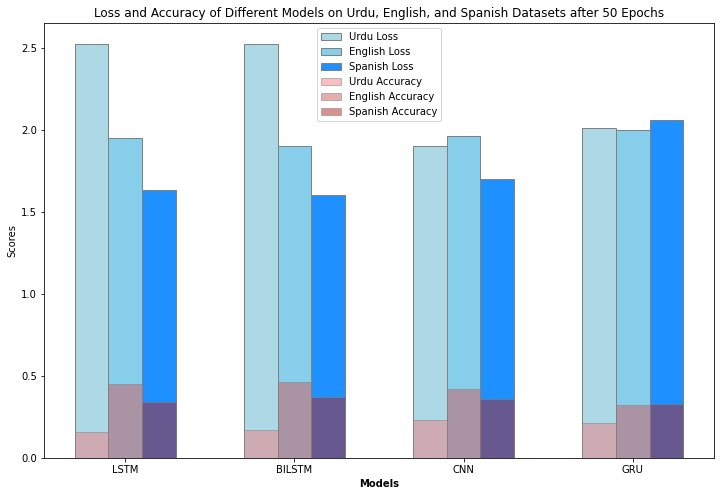

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Define the data
models = ["LSTM", "BILSTM", "CNN", "GRU"]
urdu_loss = [2.525, 2.52, 1.90, 2.01]
urdu_accuracy = [0.155, 0.17, 0.23, 0.21]
english_loss = [1.95, 1.90, 1.96, 2.00]
english_accuracy = [0.45, 0.46, 0.42, 0.32]
spanish_loss = [1.63, 1.60, 1.70, 2.06]
spanish_accuracy = [0.34, 0.37, 0.36, 0.33]

# Set the width of the bars
bar_width = 0.2

# Set the positions of the bars on the x-axis
r1 = np.arange(len(models))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Create a bar graph for loss
plt.figure(figsize=(12, 8))
plt.bar(r1, urdu_loss, color='lightblue', width=bar_width, edgecolor='grey', label='Urdu Loss')
plt.bar(r2, english_loss, color='skyblue', width=bar_width, edgecolor='grey', label='English Loss')
plt.bar(r3, spanish_loss, color='dodgerblue', width=bar_width, edgecolor='grey', label='Spanish Loss')

# Create a bar graph for accuracy
plt.bar(r1, urdu_accuracy, color='lightcoral', width=bar_width, edgecolor='grey', label='Urdu Accuracy', alpha=0.5)
plt.bar(r2, english_accuracy, color='indianred', width=bar_width, edgecolor='grey', label='English Accuracy', alpha=0.5)
plt.bar(r3, spanish_accuracy, color='firebrick', width=bar_width, edgecolor='grey', label='Spanish Accuracy', alpha=0.5)

# Add labels and title
plt.xlabel('Models', fontweight='bold')
plt.xticks([r + bar_width for r in range(len(models))], models)
plt.ylabel('Scores')
plt.title('Loss and Accuracy of Different Models on Urdu, English, and Spanish Datasets after 50 Epochs')

# Add legend
plt.legend()

# Show the plot
plt.show()


### Accuracy and loss of different models after 100 epochs

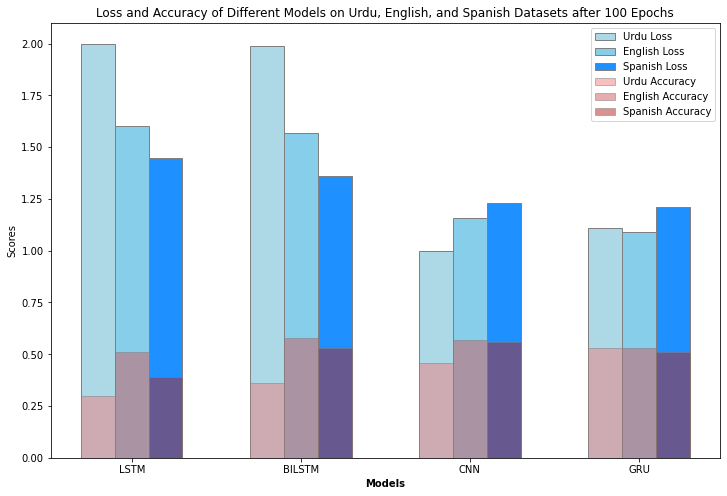

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Define the data
models = ["LSTM", "BILSTM", "CNN", "GRU"]
urdu_loss = [2.00, 1.99, 1.00, 1.11]
urdu_accuracy = [0.30, 0.36, 0.46, 0.53]
english_loss = [1.60, 1.57, 1.16, 1.09]
english_accuracy = [0.51, 0.58, 0.57, 0.53]
spanish_loss = [1.45, 1.36, 1.23, 1.21]
spanish_accuracy = [0.39, 0.53, 0.56, 0.51]

# Set the width of the bars
bar_width = 0.2

# Set the positions of the bars on the x-axis
r1 = np.arange(len(models))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Create a bar graph for loss
plt.figure(figsize=(12, 8))
plt.bar(r1, urdu_loss, color='lightblue', width=bar_width, edgecolor='grey', label='Urdu Loss')
plt.bar(r2, english_loss, color='skyblue', width=bar_width, edgecolor='grey', label='English Loss')
plt.bar(r3, spanish_loss, color='dodgerblue', width=bar_width, edgecolor='grey', label='Spanish Loss')

# Create a bar graph for accuracy
plt.bar(r1, urdu_accuracy, color='lightcoral', width=bar_width, edgecolor='grey', label='Urdu Accuracy', alpha=0.5)
plt.bar(r2, english_accuracy, color='indianred', width=bar_width, edgecolor='grey', label='English Accuracy', alpha=0.5)
plt.bar(r3, spanish_accuracy, color='firebrick', width=bar_width, edgecolor='grey', label='Spanish Accuracy', alpha=0.5)

# Add labels and title
plt.xlabel('Models', fontweight='bold')
plt.xticks([r + bar_width for r in range(len(models))], models)
plt.ylabel('Scores')
plt.title('Loss and Accuracy of Different Models on Urdu, English, and Spanish Datasets after 100 Epochs')

# Add legend
plt.legend()

# Show the plot
plt.show()


### Accuracy and loss of different models after 150 epochs

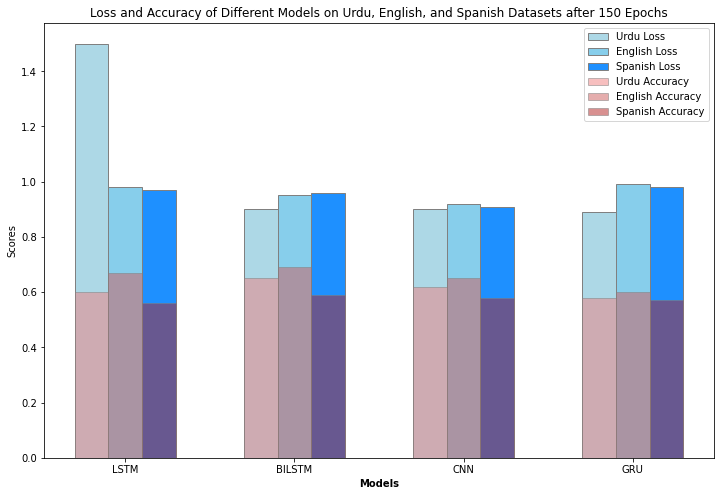

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# Define the data
models = ["LSTM", "BILSTM", "CNN", "GRU"]
urdu_loss = [1.50, 0.90, 0.90, 0.89]
urdu_accuracy = [0.60, 0.65, 0.62, 0.58]
english_loss = [0.98, 0.95, 0.92, 0.99]
english_accuracy = [0.67, 0.69, 0.65, 0.60]
spanish_loss = [0.97, 0.96, 0.91, 0.98]
spanish_accuracy = [0.56, 0.59, 0.58, 0.57]

# Set the width of the bars
bar_width = 0.2

# Set the positions of the bars on the x-axis
r1 = np.arange(len(models))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Create a bar graph for loss
plt.figure(figsize=(12, 8))
plt.bar(r1, urdu_loss, color='lightblue', width=bar_width, edgecolor='grey', label='Urdu Loss')
plt.bar(r2, english_loss, color='skyblue', width=bar_width, edgecolor='grey', label='English Loss')
plt.bar(r3, spanish_loss, color='dodgerblue', width=bar_width, edgecolor='grey', label='Spanish Loss')

# Create a bar graph for accuracy
plt.bar(r1, urdu_accuracy, color='lightcoral', width=bar_width, edgecolor='grey', label='Urdu Accuracy', alpha=0.5)
plt.bar(r2, english_accuracy, color='indianred', width=bar_width, edgecolor='grey', label='English Accuracy', alpha=0.5)
plt.bar(r3, spanish_accuracy, color='firebrick', width=bar_width, edgecolor='grey', label='Spanish Accuracy', alpha=0.5)

# Add labels and title
plt.xlabel('Models', fontweight='bold')
plt.xticks([r + bar_width for r in range(len(models))], models)
plt.ylabel('Scores')
plt.title('Loss and Accuracy of Different Models on Urdu, English, and Spanish Datasets after 150 Epochs')

# Add legend
plt.legend()

# Show the plot
plt.show()


### Function to test BiLSTM model

In [ ]:
# Function to test BiLSTM model
def test_BiLSTM_Model(text):
    # Load the pre-trained BiLSTM model
    model = tf.keras.models.load_model("bilstm_model.h5")

    # Generate text using the BiLSTM model
    seed_text = text
    next_words = 25
    generated_text = seed_text
    for _ in range(next_words):
        # Tokenize the seed text
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        # Pad the token list
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        # Predict the next word
        predicted = np.argmax(model.predict(token_list), axis=-1)
        output_word = ""
        # Map predicted index to word
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        # Append the predicted word to the seed text
        seed_text += " " + output_word
        generated_text += " " + output_word

    return generated_text


In [ ]:
# Example seed text
seed_text = "The sun "

# Generate text using the BiLSTM model
generated_text = test_BiLSTM_Model(seed_text)
print("Generated Text:")
print(generated_text)
